Project: Baryon mass fraction from galaxies at z=0 from survey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
import scipy
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math


In [31]:
# Sersic general equation for any n. Eq. 2.22 from Galaxy Formation & Evolution 
# Need to define Reff first
# Bn 2n-0.324 (but only for n=>1) (B beta)
# To write I(R) in terms of L_tot instead of I0:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n))} exp[-bn(R/Re)**(1/n)]
# To write I(R) in terms of L_tot instead of Ie:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n)*exp(bn))} exp[-bn{(R/Re)**(1/n)-1}]


Mgsol = 5.11 #banda g
Misol = 4.53 #banda i

def I0_to_Ie(I0):
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324 
    
    return I0/np.exp(Bn)

def Ie_to_I0(Ie):
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324 
    
    return Ie*np.exp(Bn)
    
    

def Ltot_to_I0(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns I0
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function
    
    I0 = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm
    
    return I0

def Ltot_to_Ie(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns Ie
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma/np.exp(Bn)
    
    Bn = 2*n-0.324
    
    gm = math.gamma(2*n)  #gamma function
    
    Ie = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm/np.exp(Bn)
    
    return Ie
    

def sersic_profile(r, Ie, n, Re):
    # I0 puede ser L_tot
    # The surface brightness profile of spheroidal galaxies is generally well fit by the Sersic profile
    # Compare to sersic mass density 
    # I(R) = I0*exp[-Bn(R/Re)**(1/n)] = Ie*exp[-Bn{(R/Re)**(1/n)-1}]
    # Ie = I0/exp(Bn)
    # Inputs: radius, Intesity, sersic index, Reff
    # units are Lsun / kpc**2
    # Eq 2.22 from Galaxy Formation & Evolution
   
    Bn = 2*n-0.324
    ratio = (r/Re)**(1/n)
    exponent = -Bn*(ratio-1)
    
    return Ie*np.exp(exponent)



def L_profile(r, Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system but as a function of radius. 
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR)
    # integrate sersic profile from 0 to R
    # inputs:
    #        radius, Intensity(e), sersic index, R eff
    
    def L(r, Ie, n, Re):
        
        return 2*np.pi*sersic_profile(r, Ie, n, Re)*r
    
    I = integrate.quad(L, 0 ,r, args=(Ie, n, Re))
    
    ansI = I[0]
    
    return ansI

def L_tot(Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # Inputs :
    #         Intensity(e), sersic index, Eff rad
    # L = 2*pi*integral(I(R)RdR) = (2*pi*G(2n)/(Bn)**(2*n))*I0*Re**2
    # integrate sersic profile from 0 to inf
    # Returns the total Luminosity
    "units of Lsun?"
    
    Bn = 2*n-0.324
    
    gm = math.gamma(2*n)  #gamma function buscar funcion completa
    
    I0 = Ie*np.exp(Bn)    
    
    L = (2*np.pi*n*gm/(Bn)**(2*n))*I0*Re**2
    
    return L

def abs_mag_to_log10Lx(Mabs_x, Mabs_xsol):
    "do we need this?"
#     Input: x = band, Mx = absolute magnitude of a given object at a given band
#     Returns the total luminosity at a given band of the galaxy
#     M_gsol = 5.11 #banda g 
#     M_isol = 4.53 #banda i
#     Log(L_x/L_xsol) = -0.4* (M_x - M_xsol) 
#     Eq 2.6 from Galaxy Formation & Evolution
#     This returns the LOG of the luminosity!
    
    return -0.4*(Mabs_x-Mabs_xsol) #### Log(Lx/L_xsol)


def Lx_to_abs_mag(Lx, Mabs_xsol):
    # M_x  =  -2.5 *log(L_x/L_xsol) + M_xsol
    # It takes L_profile as input to make it an absolute magnited as a function of radius
    # Substract two different bands to get the color
    "unitless right?"

    return -2.5 * np.log10(Lx) + Mabs_xsol #### Absolute Magnitude


# def M_x(r, log10Lx, Mabs_xsol, Re, n):
#     # Computes the absolute magnitude as a function of radius
#     # Inputs: Lx = luminosity of a given band & M_xsun = magnitude of the sun of a given band, Re= effective radius, n sersic index
    
    
#     Lx = 10**(log10Lx)
    
#     Iex = Ltot_to_Ie(Lx, Re, n) # converts the total luminosity to the intensity
    
#     Lx_prof  = L_profile(r, Iex, n, Re) # coverts the intensity of the given band to the luminosty profile as a
#                                          # function of radius
       
        
#     return Lx_to_abs_mag(Lx_prof,Mabs_xsol)


# def color(Lx, Ly, Mabs_xsol, Mabs_ysol, Rex, Rey, Iex, Iey, nx, ny):
    
# # difference between absolute magnitudes between two bands 
# # color as a function of radius
# # inputs:
# #       M_g, M_i

#     Lx_prof  = L_profile(r, Iex, nx, Rex)
    
#     Ly_prof  = L_profile(r, Iey, ny, Rey)
    
#     MX = Lx_to_abs_mag(Lx_prof, Mabs_xsol)
    
#     MY = Lx_to_abs_mag(Ly_prof, Mabs_xsol)
  
#     return MX - MY
    
    
    
def stellar_mass_profile(r, Ie, n, Re, Mxg, Mxi):
 #   "units of solar mass/kpc?"
# Log(Ms/Msol) = -0.68 + 0.73 * (g-i)  + log10(L_i/L_isol)
# To make it a function of radius
# Inputs:
#       radius, Intensity(e), sersic index, Magnitudes of the g and i bands
    
    
    Lpi = L_profile(r, Ie, n, Re) # We need the luminosity profile of the i band to make it a function of radius 
    
    color = Mxg - Mxi 
    
    return -0.68 + 0.73 * color  + np.log10(Lpi)


def stellar_mass(LtI, Mxg, Mxi):
# Log(Ms/Msol) = -0.68 + 0.73 * (g-i)  + log10(L_i/L_isol)
# Total stellar mass 
# Instead of the Luminosity profile, we use the total luminosity
#"only units of solar mass?"
    
    color = Mxg - Mxi 
    
    return -0.68 + 0.73 * color  + np.log10(LtI)


def r_effective(r, Ltot, Mxg,Mxi,Ie, n, Re):
    # Computes the effective (mass) radius. Where half of the total mass is located
    #  total_stellar_mass/2 = stellar_mass_profile 
    
    def f(r, Ltot, Mxg, Mxi, Ie, n, Re):
        
        return (stellar_mass(LtI,Mxg,Mxi)/2) - stellar_mass_profile(r, Ie, n, Re, Mxg, Mxi)
    
    r_m2 = optimize.bisect(f, 0, 100, args=(Ltot, Mxg, Mxi, Ie, n, Re))
    
    return r_m2
    




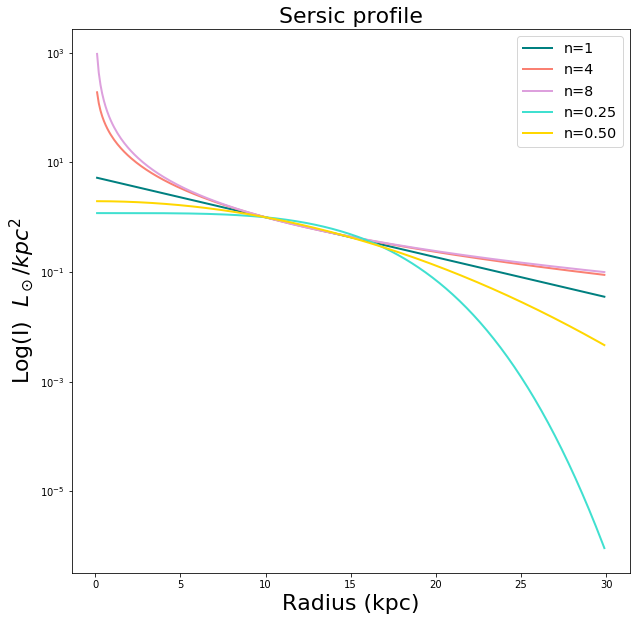

In [6]:
####### Sersic Profile ########

r = np.arange(0.1, 30, 0.1)


sm_n025 = sersic_profile(r, 1, 0.25, 10)
sm_n050 = sersic_profile(r, 1, 0.50, 10)
sm_n1 = sersic_profile(r, 1, 1, 10)
sm_n4 = sersic_profile(r, 1, 4, 10)
sm_n8 = sersic_profile(r, 1, 8, 10)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ax.set_title("Sersic profile", fontsize=22)
plt.semilogy(r, (sm_n1), '-', color='teal', linewidth=2, label='n=1')
plt.semilogy(r, (sm_n4), '-', color='salmon', linewidth=2, label='n=4')
plt.semilogy(r, (sm_n8), '-', color='plum', linewidth=2, label='n=8')
plt.semilogy(r, (sm_n025), '-', color='turquoise',linewidth=2, label='n=0.25')
plt.semilogy(r, (sm_n050), '-', color='gold',linewidth=2, label='n=0.50')
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Log(I)  $L_\odot/kpc^2$', fontsize=22)
plt.legend(loc='upper right', fontsize = 'x-large')
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.show()

In [7]:
# We are going to get the effective radius not form the luminosity but from the mass
# at large radius make sure L-profile  is equal to Ltot
# at 30kpc or wherever it flattens
# L_profile (r, Ie, n, Re)
# L_tot (Ie, n, Re)
# 2 figures, L_prof, color vs radius,

#############Data#########################
# Banda g del SDSS: 4770 angstroms (green)
# Magnitud Absoluta = M_g = -19.80323 magnitudes
# Radio efectivo = Re = 3.91504 kpc
# Indice de Sersic = ns = 3.6546
###########Data#########################
# Banda i del SDSS: 7625 angstroms
# Magnitud Absoluta = M_i = -20.90624 magnitudes
# Radio efectivo = Re = 4.10757 kpc
# Indice de Sersic = ns = 3.56484

In [8]:
#Test magnitude to luminosity works
Mxg = -19.80323
Mxi = -20.90624
log10Lg = abs_mag_to_log10Lx(Mxg, Mgsol)
log10Li = abs_mag_to_log10Lx(Mxi, Misol)



In [9]:
# Sersic index
ng = 3.6546
ni = 3.56484

# Effective Radius
Rg = 3.91504
Ri = 4.10757 

# Magnitude
Mxg = -19.80323
Mxi = -20.90624

# changing magnitude to luminosity
L_g = 10**(abs_mag_to_log10Lx(Mxg, Mgsol)) 
L_i = 10**(abs_mag_to_log10Lx(Mxi, Misol))


print('L_g = ',L_g)
print('L_i = ',L_i)


# changing luminosity to intensity
Ie_g = Ltot_to_Ie(L_g, Rg, ng)
Ie_i = Ltot_to_Ie(L_i, Ri, ni)



print('Ie_g = ', Ie_g)
print('Ie_i = ',Ie_i)

# Making sure l_profile is equal to L_tot at large radius
#radius = np.logspace(-1, 1.2, 100)

LpG = L_profile(1000*Rg, Ie_g, ng, Rg)
LtG = L_tot(Ie_g, ng, Rg)
LpI = L_profile(1000*Ri, Ie_i, ni, Ri)
LtI = L_tot(Ie_i, ni, Ri)



L_g =  9231919311.01699
L_i =  14945002774.468317
Ie_g =  27764025.218844924
Ie_i =  41321957.0709973


In [140]:
print('L prof = ',LpG)  ### checking these values must be the same at lage radii
print('L tot = ',LtG)

L prof =  9231919311.021948
L tot =  9231919311.016989


In [141]:
print('L prof = ',LpI)
print('L tot = ',LtI)

L prof =  14945002774.473999
L tot =  14945002774.468317


In [142]:
print(Mg, Mi)

54.619498850116514 56.79730766631114


In [10]:
Msp = stellar_mass_profile(1000*Ri, Ie_i, ni, Ri, Mxg, Mxi) ### checking these values must be the same at lage radii
Mst = stellar_mass(LtI, Mxg, Mxi)
print('mass profile', Msp)
print('total mass', Mst)

mass profile 10.299693300000166
total mass 10.299693300000001


In [32]:
r_effective(1000*Ri, LtI, Mxg,Mxi,Ie_i, ni, Ri)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:186: RuntimeWarning: divide by zero encountered in log10


0.0012947397365792312

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:186: RuntimeWarning: divide by zero encountered in log10


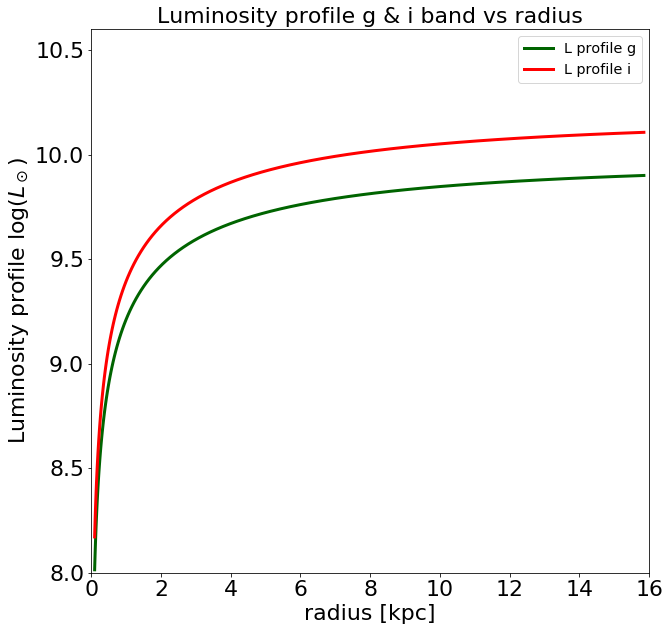

In [24]:
###### Plotting Luminosity profile ############

color = Mxg - Mxi
LpG= []
LpI = []
Mag_G = []
Mag_I = []
Mx_g = []
Col_gal = []
Log_Ms_prof = []



radius = np.logspace(-1, 1.2, 100)
for i in range(0, 100):
    LpG.append(L_profile(radius[i], Ie_g, ng, Rg))
    LpI.append(L_profile(radius[i], Ie_i, ni, Ri))
    Mag_G.append(Lx_to_abs_mag(LpG[i],Mgsol))
    Mag_I.append(Lx_to_abs_mag(LpI[i],Misol))
    Col_gal.append(Mag_G[i]-Mag_I[i])
    Log_Ms_prof.append(stellar_mass_profile(radius[i], Ie_i, ni, Ri, Mxg, Mxi))
    
   

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ax.set_title("Luminosity profile g & i band vs radius", fontsize=22)
plt.plot(radius, np.log10(LpG), '-', color='darkgreen', linewidth=3, label='L profile g')
plt.plot(radius, np.log10(LpI), '-', color='red', linewidth=3, label='L profile i')


plt.xlabel('radius [kpc]', fontsize = 22)
plt.ylabel('Luminosity profile log($L_\odot$)', fontsize = 22)
plt.ylim(8, 10.6)         
plt.xlim(0,16)  
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

legend = ax.legend(loc='upper right',fontsize='x-large')
plt.show()




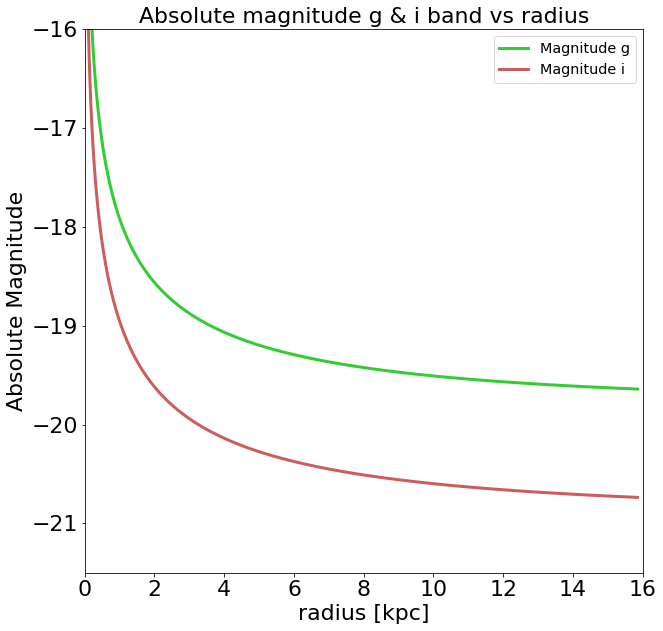

In [21]:
######## Plotting magnitude #######

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.title('Absolute magnitude g & i band vs radius', fontsize = 22)
plt.plot(radius, Mag_G, '-', color='limegreen', linewidth=3, label='Magnitude g')
plt.plot(radius, Mag_I, '-', color='indianred', linewidth=3, label='Magnitude i')



plt.xlabel('radius [kpc]', fontsize = 22)
plt.ylabel('Absolute Magnitude', fontsize = 22)
plt.ylim(-21.5, -16)         
plt.xlim(0,16)
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

legend = ax.legend(loc='upper right',fontsize='x-large')
plt.show()

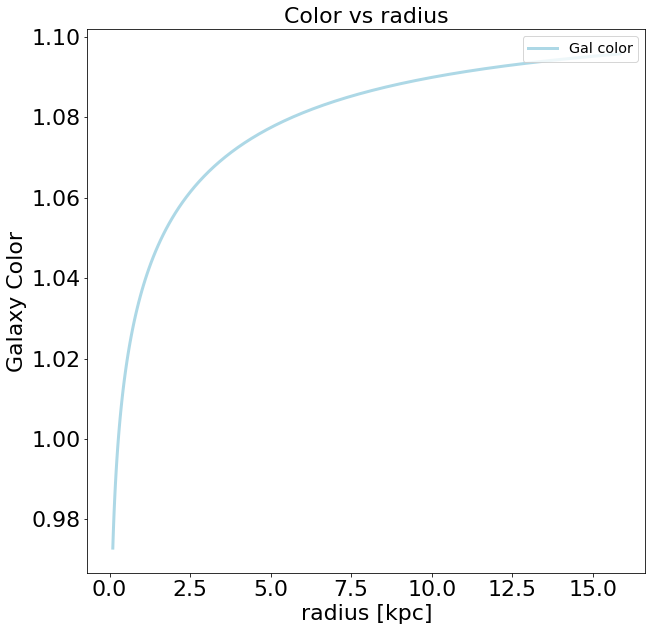

In [22]:
##### Plotting color VS radius ###########

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.title('Color vs radius', fontsize = 22)
plt.plot(radius, Col_gal, color='lightblue',linewidth=3, label='Gal color')
plt.xlabel('radius [kpc]', fontsize = 22)
plt.ylabel('Galaxy Color', fontsize = 22)
# plt.ylim(0, 1.5)         
# plt.xlim(0,16)
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

legend = ax.legend(loc='upper right',fontsize='x-large')
plt.show()

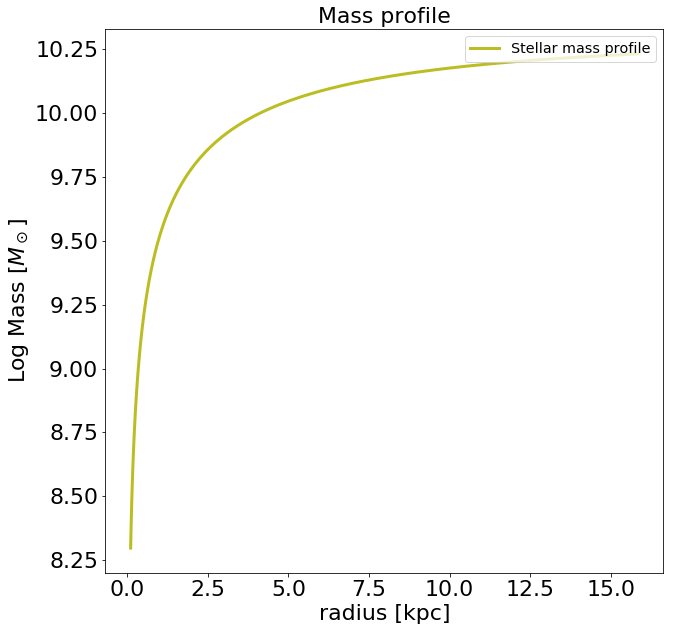

In [25]:
####### Plotting Mass profile ###############

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.title('Mass profile', fontsize = 22)
plt.plot(radius, Log_Ms_prof, color='tab:olive',linewidth=3, label='Stellar mass profile')
plt.xlabel('radius [kpc]', fontsize = 22)
plt.ylabel('Log Mass [$M_\odot$]', fontsize = 22)
# plt.ylim(0, 1.5)         
# plt.xlim(0,16)
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

legend = ax.legend(loc='upper right',fontsize='x-large')
plt.show()